# keras original model
sound model 에서 log_spectrogram 을 사용해준 간단한 분류 모델이다. 

In [1]:
import os
import numpy as np
from scipy.fftpack import fft
from scipy.io import wavfile
from scipy import signal
from glob import glob
import re
import pandas as pd
import gc
from scipy.io import wavfile

from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
import keras
import time
import datetime

from keras.models import Sequential 
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import h5py

# import keras necessary classes
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
import numpy as np
import pandas as pd

import numpy as np
import random
import itertools
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt


import numpy as np
import random
import itertools
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt


#import glob
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
%matplotlib notebook
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12591849519641756294
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 6955846861
locality {
  bus_id: 1
}
incarnation: 10606220190578715036
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0"
]


In [3]:
L = 16000
legal_labels = 'yes no up down left right on off stop go silence unknown'.split()
#legal_labels = 'bed bird cat dog down eight five four go happy house left marvin nine no off on one right seven sheila six stop three tree two up wow yes zero silence unknown'.split()

#src folders
root_path = r'.'
out_path = r'.'
model_path = r'.'
train_data_path = os.path.join(root_path, 'input', 'train', 'audio')
test_data_path = os.path.join(root_path, 'input', 'test', 'audio')

#train_data_path = os.path.join(root_path, 'input', 'train_test')
#test_data_path = os.path.join(root_path, 'input', 'test', 'audio')

In [4]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    vals = 2.0/N * np.abs(yf[0:N//2])
    return xf, vals

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [5]:
def list_wavs_fname(dirpath, ext='wav'):
    #print(dirpath)
    fpaths = glob(os.path.join(dirpath, r'*/*' + ext))
    pat = r'.+/(\w+)/\w+\.' + ext + '$'
    labels = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            labels.append(r.group(1))
    pat = r'.+/(\w+\.' + ext + ')$'
    fnames = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            fnames.append(r.group(1))
    return labels, fnames

In [6]:
def pad_audio(samples):
    if len(samples) >= L: return samples
    else: return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))

def chop_audio(samples, L=16000, num=20):
    for i in range(num):
        beg = np.random.randint(0, len(samples) - L)
        yield samples[beg: beg + L]

def label_transform(labels):
    nlabels = []
    for label in labels:
        if label == '_background_noise_':
            nlabels.append('silence')
        elif label not in legal_labels:
            nlabels.append('unknown')
        else:
            nlabels.append(label)
    return pd.get_dummies(pd.Series(nlabels))

In [7]:
labels, fnames = list_wavs_fname(train_data_path)

In [8]:
print('start')
#print(fnames)
start_time = time.time();
new_sample_rate = 8000
y_train = []
x_train = []
log_specgrams = []
labelbase = ""
k = 0
bands = 96
frames = 41
i = 0
for label, fname in zip(labels, fnames):
    sample_rate, samples = wavfile.read(os.path.join(train_data_path, label, fname))

    if labelbase != label:
        print(label,k)
        labelbase = label
        #k = 0
        i = 0
    else:
        k = k+1
    
    samples = pad_audio(samples)
    if len(samples) > 16000:
        #print('chop->',label,fname)
        n_samples = chop_audio(samples)
    else: n_samples = [samples]
        #print('else->',label,fname)
    sampleglobal = samples

    for samples in n_samples:
        
        resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
    
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
     
        if i==0:
            #plt.imshow(specgram)
            i= i + 1
        else:
            i=0
        
        y_train.append(label)
        x_train.append(specgram)
print("--- %s seconds ---" % str(datetime.timedelta(seconds=(time.time() - start_time))))

start
bird 0
six 1730
down 4098
one 6456
happy 8825
sheila 10566
up 12299
bed 14673
two 16385
on 18757
wow 21123
right 22867
tree 25233
zero 26965
five 29340
house 31696


/home/jake/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


_background_noise_ 33445
go 33450
three 35821
off 38176
seven 40532
four 42908
stop 45279
nine 47658
dog 50021
cat 51766
left 53498
yes 55850
eight 58226
marvin 60577
no 62322
--- 0:08:53.791799 seconds ---


<IPython.core.display.Javascript object>


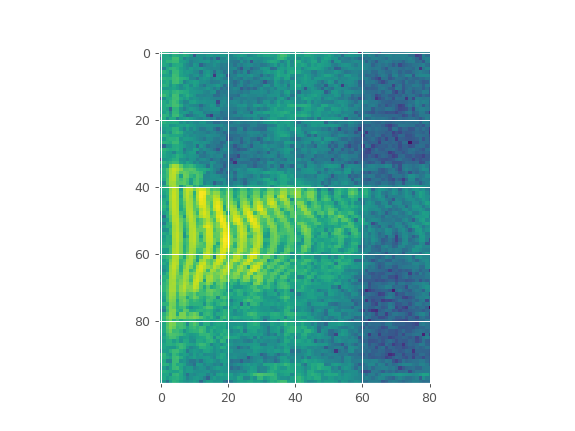

AxesImage(80,52.8;496x369.6)


In [9]:
print(plt.imshow(x_train[51766]))

In [10]:
x_train = np.array(x_train)
x_train = x_train.reshape(tuple(list(x_train.shape) + [1]))
y_train = label_transform(y_train)
label_index = y_train.columns.values
y_train = y_train.values
y_train = np.array(y_train)
del labels, fnames
gc.collect()

7

In [11]:
print(x_train[0].shape, y_train.shape)

(99, 81, 1) (64841, 12)


In [ ]:
# 모델 불러오기 

from keras.models import load_model
#model = load_model('cnn_epochs3_20171211.model')
#model = load_model('./labelChange.model')

In [12]:
n1 = 99
n2 = 81
n3 = 1
nclass = len(np.array(legal_labels))-1
input_shape = (n1,n2,1)
nclass = 12

In [13]:
#original
#model-1
print('start')
input_shape = (99, 81, 1)
#input_shape  = (n1,n2,2)

#nclass = len(np.array(legal_labels))-1
#nclass = nclass
start_time = time.time();
inp = Input(shape=input_shape)
norm_inp = BatchNormalization()(inp)
img_1 = Convolution2D(8, kernel_size=2, activation=activations.relu)(norm_inp)
img_1 = Convolution2D(8, kernel_size=2, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)

img_1  = ZeroPadding2D((1,1))(img_1)

img_1 = Convolution2D(16, kernel_size=3, activation=activations.relu)(img_1)
img_1 = Convolution2D(16, kernel_size=3, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)

img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu,data_format='channels_first')(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)

#deeper
#img_1 = Convolution2D(8, kernel_size=2, activation=activations.relu, data_format='channels_first')(img_1)
#img_1 = Convolution2D(8, kernel_size=2, activation=activations.relu)(img_1)
#img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
#img_1 = Dropout(rate=0.2)(img_1)


img_1 = Flatten()(img_1)

dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(img_1))
dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(dense_1))
dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

model = models.Model(inputs=inp, outputs=dense_1)
opt = optimizers.Adam()

model.compile(optimizer=opt, loss=losses.binary_crossentropy)
model.summary()

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=2017)
#vgg
batch_size = 128
nb_epoch = 1

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.fit(x_train,y_train,nb_epoch= nb_epoch,batch_size = batch_size , validation_split=0.1)
model.fit(x_train, y_train, batch_size=128, validation_data=(x_valid, y_valid), epochs=20, shuffle=True, verbose=1)
model.save(os.path.join(model_path, 'labelChange.model'))
print("finish")

start
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 99, 81, 1)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 99, 81, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 80, 8)         40        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 79, 8)         264       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 39, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 39, 8)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 50, 41, 8)         0         
____

In [15]:
test_data_path = './input/test/audio_test/'

In [16]:
#original model
def test_data_generator(batch=16):
    fpaths = glob(os.path.join(test_data_path, '*wav'))
    i = 0
    for path in fpaths:
        if i == 0:
            imgs = []
            fnames = []
        i += 1
        rate, samples = wavfile.read(path)
        samples = pad_audio(samples)
        resampled = signal.resample(samples, int(new_sample_rate / rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        imgs.append(specgram)
        fnames.append(path.split('\\')[-1])
        if i == batch:
            i = 0
            imgs = np.array(imgs)
            imgs = imgs.reshape(tuple(list(imgs.shape) + [1]))
            yield fnames, imgs
    if i < batch:
        imgs = np.array(imgs)
        imgs = imgs.reshape(tuple(list(imgs.shape) + [1]))
        yield fnames, imgs
    raise StopIteration()

In [18]:
#extract feature test
from glob import glob
new_sample_rate = 8000
print('start')
start_time = time.time();
index = []
results = []
for fnames, imgs in test_data_generator(batch=32):
    predicts = model.predict(imgs)
    predicts = np.argmax(predicts, axis=1)
    predicts = [label_index[p] for p in predicts]
    index.extend(fnames)
    results.extend(predicts)

index = [w.replace('./input/test/audio_test/', '') for w in index]
df = pd.DataFrame(columns=['fname', 'label'])
df['fname'] = index
df['label'] = results

df.to_csv(os.path.join(out_path, 'sub_300.csv'), index=False)
print("--- %s seconds ---" % str(datetime.timedelta(seconds=(time.time() - start_time))))

start
--- 0:00:00.298504 seconds ---
